In [1]:
%matplotlib inline
from pylab import *

import shutil
import sys
import os.path
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.optimize import minimize
import itertools
import pyomo.environ as env
import ast
from pyomo.environ import *

import networkx as nx
from networkx.drawing.nx_agraph import write_dot, graphviz_layout

In [42]:
### FLOW IN MUST BE IN M3/DAY OR MGD###

In [ ]:
# required inputs from user for this UP:
deep_bed_denitrifying_filter = True

In [43]:
flow_in = 30
unit = 'mgd'

In [ ]:
#unit conversion needed for model
if unit == 'mgd':
    mgd_to_m3d = 3.7854
    flow_in = flow_in / mgd_to_m3d

In [44]:
# USER INPUTS: FINANCIAL INFORMATION
fixed_op_cost_scaling_exp = 0.7 # source:
basis_year = 2014 # meaning:
analysis_yr_cost_indicies = 2025
last_year_for_cost_indicies = 2050
on_stream_factor = 0.95

salaries_percent_FCI = 0.01 #represented as a fraction. source:
land_cost_precent_FCI = 0.0015 #represented as a fraction. source:
working_cap_precent_FCI = 0.05 #represented as a fraction. source:
maintinance_costs_precent_FCI =  0.03
lab_fees_precent_FCI = 0.01
insurance_taxes_precent_FCI = 0.007

benefit_percent_of_salary = 0.9

elec_price = 0.01

fixed_op_cost_scaling_exp = 0.7

In [ ]:
# Perfomance Parameter Values for Process: Constituent removals. If not here, assume 0.
TOC_removal = 0.2 # Asano et al (2007)
if deep_bed_denitrifying_filter == True:
    nitrate_removal = 0.8 #Mohseni-Bandpi et al., 2013
    TOrC_removal = 0.2 # Reungoat et al. (2009) and Falas et al. (2016)
    EEQ_removal = 0.2 # Reungoat et al. (2009) and Falas et al. (2016)
    
    

In [46]:
# captial costs basis
#Project Cost for Filter = $725,570 x (flow in mgd) 0.5862 with R2 = 0.996 (page 55)
# note: says not to extrapolate beyond 30 MGD but we do if needed.
base_fixed_cap_cost = 0.725570 #from TWB
cap_scaling_exp = 0.586 #from TWB

In [47]:
# fixed operating costs
base_employee_salary_cost = base_fixed_cap_cost * salaries_percent_FCI

In [48]:
# cost index values
df = pd.read_csv('plant_cost_indices.csv')
df = get_ind_table(df)
cap_replacement_parts = df.loc[basis_year].Capital_Factor
catalysts_chemicals = df.loc[basis_year].CatChem_Factor
labor_and_other_fixed = df.loc[basis_year].Labor_Factor
consumer_price_index = df.loc[basis_year].CPI_Factor

linear score for: Capital_Index 0.877954275463864
linear score for: CatChem_Index 0.949814194982533
linear score for: Labor_Index 0.9812970929946648
linear score for: CPI_Index 0.9954947443915652


In [49]:
# capital costs (unit: MM$) ---> TCI IN EXCEL
fixed_cap_inv_unadjusted = base_fixed_cap_cost * (flow_in *mgd_to_m3d) ** cap_scaling_exp
fixed_cap_inv = fixed_cap_inv_unadjusted * cap_replacement_parts
land_cost = fixed_cap_inv * land_cost_precent_FCI
working_cap = fixed_cap_inv * working_cap_precent_FCI
total_cap_investment = fixed_cap_inv + land_cost + working_cap

In [50]:
# variable operating costs (unit: MM$/yr) -> MIKE TO DO -> ---> CAT+CHEM IN EXCEL
# --> should be functions of what is needed!?
#cat_chem_df = pd.read_csv('catalyst_chemicals.csv')
#cat_and_chem = flow_in * 365 * on_stream_factor # TODO
electricity = 0 #flow_in * 365 * on_stream_factor * elec_price # TODO
cat_and_chem_cost = 0 # TODO
electricity_cost = electricity * elec_price * 365 # KWh/day * $/KWh * 365 days
other_var_cost = cat_and_chem_cost - electricity_cost

In [51]:
# fixed operating cost (unit: MM$/yr)  ---> FIXED IN EXCEL
salaries = labor_and_other_fixed * base_employee_salary_cost * (flow_in *mgd_to_m3d)** fixed_op_cost_scaling_exp
benefits = salaries * benefit_percent_of_salary
maintenance = maintinance_costs_precent_FCI * fixed_cap_inv
lab = lab_fees_precent_FCI * fixed_cap_inv
insurance_taxes = insurance_taxes_precent_FCI * fixed_cap_inv
total_fixed_op_cost = salaries + benefits + maintenance + lab + insurance_taxes


In [ ]:
total_up_cost = total_cap_investment +  cat_and_chem_cost +  electricity_cost + other_var_cost + total_fixed_op_cost 

In [3]:
import media_filtration_twb as up
import watertap as wt

adding unit process to network: media_filtration_twb
adding unit process attributes: media_filtration_twb
goes into adding unit attributes 2
edge ('media_filtration_twb_start', 'media_filtration_twb_end')


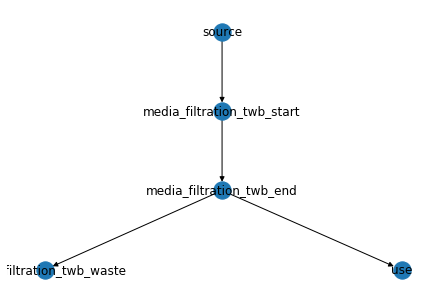

In [4]:
# imports all trains from library/unit processes
unit_process_name_list = [wt.unit_process_library_list[0]] #[wt.unit_process_library_list[0], wt.unit_process_library_list[1]] 
#wt.unit_process_library_list

# FROM AND TO PROCESS TO BE CHANED TO SINGLE VS TRAIN OPTION - HAVE TWO OPTIONS. START WITH TRAIN.
T = wt.treatment_train_design.create_train(unit_process_name_list=unit_process_name_list,  # OLDER VERSION HAD TO AND FROM PROCESS BUT THAT IS FOR ADDING ONE PROCESS AT A TIME
                                            #unit_process = 'microfiltration',
                                            source_water_reference = 'Poseidon',
                                            source_water_type = 'Wastewater',
                                            source_water_case_study ='Typical untreated domestic wastewater',
                                            enduse_water_reference = 'Poseidon',
                                            enduse_water_type = 'Environmental',
                                            enduse_water_case_study = 'EPA: Environmental Reuse',
                                            flow = 1000.0)

wt.display.treatment_train_graph(T)

In [5]:
def get_up_module(G, up_edge):
        
    G.edges[up_edge]['treatment_name'] == 'media_filtration_twb'
    import media_filtration_twb as up
    
    return up

In [6]:
unit_process = 'media_filtration_twb'

start_node = ('%s_start' % unit_process)
end_node = ('%s_end' % unit_process)
up_edge = (start_node, end_node)

up = get_up_module(T, up_edge)

up.total_up_cost(flow_in = flow_in)

In [10]:
flow_in

113562.0

In [11]:
113562.0 / 5

22712.4

In [12]:
113562.0 / 3

37854.0

In [9]:
def get_ind_table(df):

    df1 = pd.DataFrame()
    for name in df.columns[1:]:
        a, b = get_linear_regression(list(df.Year), list(df[('%s' % name)]), name)
        new_list = []; yr_list = [];
        for yr in range(df.Year.max()+1, last_year_for_cost_indicies+1):
            new_list.append(a*yr + b)
            yr_list.append(yr)
        df1[name] = new_list
    df1['Year'] = yr_list
    df = pd.concat([df, df1], axis = 0)

    new_cost_variables = ['Capital', 'CatChem', 'Labor', 'CPI']
    for variable in new_cost_variables:
        ind_name = ('%s_Index' % variable)
        fac_name = ('%s_Factor' % variable)
        df[fac_name] = df[ind_name] / df[df.Year == analysis_yr_cost_indicies][ind_name].max()
    
    df = df.set_index(df.Year)
    
    return df

In [10]:
def get_linear_regression(x_values, y_values, variable):
    #print('nonlinear did not work, trying linear for:', variable)
    
    from sklearn.linear_model import LinearRegression
    X = np.array(x_values).reshape(-1, 1)
    y = np.array(y_values).reshape(-1, 1)
    reg = LinearRegression().fit(X, y)
    print('linear score for:', variable, reg.score(X, y))
    
    #a_list=[0] -> NOT SURE WHY THIS WAS HERE
    a=reg.coef_[0]
    b=reg.intercept_
    #threshold_temp=[0]

    return a[0], b[0]